# Minimize your domestic airport delays, version January 2015.

https://github.com/ninehundred1

These are the things we will look at, and the steps to do that:

1. Let's peek at the different aspects of the data

    - 1A. Parse airport data from January 2015 into a MongoDB database & add additional files
    - 1B. Plot a scatter matrix of all variables for a single day

2. Where are the most flights and delays, in the West or the East of the USA?

    - 2A. Query mongoDB by coordinates larger or smaller than the center of USA longitude
    - 2B. Create distributions and plot a bar plots of the mean departures and arrival for each day in one month (West vs East)
    - 2C. Plot distributions of the delays for West and East USA for each day of one month.
    
3.  Which airline should I choose to quickly get out of the major aiports?
    
    - 3A. Query mongoDB and load into Pandas each airline and its taxi out and carrier delay times
    - 3B. Group the data into airlines within Pandas
    - 3C. Plot the worst 10 airlines in terms of carrier delays and taxi times
    
4.  Where in the USA are the worst weather delays that affect my flights?

    - 4A. query mongoDB for weather delays and corresponding coordinates for each departure.
    - 4B. plot on map each incident of weather delay with the size of the cirlce matching delay time
    - 4C. plot a density hex map with the color matching the number of delays per hex bin area
    
5. What would be an ideal route if I want to collect my own data visiting every single airport?

    - 5A. Query mongoDB for the airport coordinates and add all airport distances into a set
    - 5B. Get each airport once and calculate all possible combinations and distances
    - 5C. Use a genetic algorithm to calculate and optimize a path with the minimal distance between all airports
    
6. Predict future delays by finding classifiers for a given a day in January, city of origin and the length of the flight using Random Forests
    - 6A. Query mongoDB for the airport coordinates, day of month, trip lenght and delays
    - 6B. Find classifiers using training data
    - 6C. Measure prediction performance using test data

## 1A. Parse airport data from January 2015 into a MongoDB database & add additional files

#### Load main CSV into MongoDB
First create and connect to a local MongoDB database we shall call FlightsUSA

In [1]:
%matplotlib inline
import pymongo

def connect_to_mongo(db,  host="localhost",  port=27017, username=None, password=None):
    """Helper function to connect to the MongoDB database, in this case stored locally on the harddrive.
    parameters: name of db
    output: mongoDB connection object
    """
    if username and password:
        mongo_login = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = pymongo.MongoClient(mongo_login)
    else:
        conn = pymongo.MongoClient(host, port)
    return conn[db]

#connect to database
database_name = "FlightsUSA_2"
db = connect_to_mongo(database_name)
print db

Database(MongoClient('localhost', 27017), u'FlightsUSA_2')


In [2]:
#parse function
import sys
import csv
from datetime import datetime

def parse_data(db, data_path, collection_name):
    """"this function parses the CSV file into the mongo database with a given collection name.
    parameters:
    db = database from connection above
    data_path = file path to csv file
    collection_name = name of collection to be generated
    """
    date_format = "%Y-%m-%d %H:%M:%S"
    with open(data_path, "r") as csvfile:
        reader_data = csv.reader(csvfile)
        for i, row in enumerate(reader_data):
            if i>0:
                #layout of the MongoDB entries, some entries are empty, fill with 0 then
                data_dict = {"DAY_OF_MONTH": float(row[0] or "0"),
                             "DAY_OF_WEEK": float(row[1]or "0"),
                             "UNIQUE_CARRIER": row[2],
                             "ORIGIN_AIRPORT_ID": row[3],
                             "ORIGIN": row[4],
                             "ORIGIN_CITY_NAME": row[5],
                             "DEST_AIRPORT_ID": row[6],
                             "DEST": row[7],
                             "DEST_CITY_NAME": row[8],
                             "CRS_DEP_TIME": float(row[9]or "0"),
                             "DEP_DELAY": float(row[10]or "0"),
                             "DEP_DELAY_GROUP": float(row[11]or "0"),
                             "TAXI_OUT": float(row[12]or "0"),
                             "TAXI_IN": float(row[13]or "0"),
                             "CRS_ARR_TIME": float(row[14]or "0"),
                             "ARR_DELAY": float(row[15]or "0"),
                             "ARR_DELAY_GROUP": float(row[16]or "0"),
                             "AIR_TIME": float(row[17]or "0"),
                             "DISTANCE": float(row[18]or "0"),
                             "CARRIER_DELAY": float(row[19]or "0"),
                             "WEATHER_DELAY": float(row[20]or "0")}
                db[collection_name].insert(data_dict)
                
#do the parse (use raw string as path)
csv_path = r'C:\Users\Meyer\Documents\GitHub\DataScience_Flights\460253913_T_ONTIME.csv'
collection_name = "flights_januar15"
#parse_data(db, csv_path, collection_name)

#### A2. Append additional CSV to databases (carrier string and airport locations)

In [3]:
#append carrier function
def add_carriers_to_db(db, collection_name, path_csv):
    """"parses in a second CSV file that has cross reference to airport names to code
    params:
    db = database from connection above
    collection_name = collection_name from above to add to 
    path_csv = file path to csv file
    """
    #open csv file with carrier legend
    with open(path_csv, "r") as csvfile:
        reader_data = csv.reader(csvfile)
        #go through all entries for carriers row by row skipping header
        for i, row in enumerate(reader_data):
            #if line has data
            if (i>0 and ''.join(row).strip()):
                #add new filed CARRIER_STRING if UNIQUE_CARRIER matches csv carrier code (row[0])
                db[collection_name].update(
                    {"UNIQUE_CARRIER": row[0]},
                    {
                    "$set": {"CARRIER_STRING": row[1]}
                    }, multi=True
                    )
                
#run above
csv_path = "C:\Users\Meyer\Documents\GitHub\DataScience_Flights\carriers.csv"
#add_carriers_to_db(db, collection_name, csv_path)

In [5]:
#append origin location function
def add_origin_coords_to_db(db, collection_name, path_csv):
    """"parses in a second CSV file that has cross reference to coordinates 
     with airport locations. This updates origins.
    params:
    db = database from connection above
    collection_name = collection_name from above to add to 
    path_csv = file path to csv file
    """
    with open(path_csv, "r") as csvfile:
        reader_data = csv.reader(csvfile)
        for i, row in enumerate(reader_data):
            if (i>0 and ''.join(row).strip()):
                db[collection_name].update(
                    {"ORIGIN": row[0]},
                    {"$set":
                        {
                        "ORIGIN_lat": float(row[5]),
                        "ORIGIN_lon": float(row[6])
                        }
                    },
                    multi=True
                    )

In [6]:
#append destination location function
def add_destination_coords_to_db(db, collection_name, path_csv):
    """"parses in a second CSV file that has cross reference to coordinates 
     with airport locations. This updates departures.
    params:
    db = database from connection above
    collection_name = collection_name from above to add to 
    path_csv = file path to csv file
    """
    with open(path_csv, "r") as csvfile:
        reader_data = csv.reader(csvfile)
        for i, row in enumerate(reader_data):
            if (i>0 and ''.join(row).strip()):
                db[collection_name].update(
                    {"DEST": row[0]},
                    {"$set":
                        {
                            "DEST_lat": float(row[5]),
                            "DEST_lon": float(row[6])
                        }
                    },
                    multi=True
                    )
                
#run both from above
csv_path = r'C:\Users\Meyer\Documents\GitHub\DataScience_Flights\airports_coords.csv'
#add_origin_coords_to_db(db, collection_name, csv_path)
#add_destination_coords_to_db(db, collection_name, csv_path)                

## 1B. Plot a scatter matrix of all variables for a single day

In [7]:
return_fields_day = ["CRS_DEP_TIME",
                         "DEP_DELAY","TAXI_OUT", "TAXI_IN", "CRS_ARR_TIME", "ARR_DELAY",
                         "AIR_TIME","DISTANCE", "CARRIER_DELAY", "WEATHER_DELAY" ]

import pandas as pd

def day_to_pandas(db, collection, return_fields):
    """"Queries to MongoDB for entries with an DAY_OF_MONTH field matching 7. 
    Then expand the cursor and loads data 
    which is specfied in return_fields into a Pandas dataframe
    params:
    db = database from connection above
    collection_name = collection_name from above to add to 
    return_fields = list of fields to transfer into pandas
    """
    cursor = db[collection_name].find(
            { 'DAY_OF_MONTH': 7 }
            ).batch_size(30)  
    
    return pd.DataFrame(list(cursor), columns = return_fields)

df_day = day_to_pandas(db, collection_name, return_fields_day)
print df_day.head()
print df_day.shape

   CRS_DEP_TIME  DEP_DELAY  TAXI_OUT  TAXI_IN  CRS_ARR_TIME  ARR_DELAY  \
0          1315         47        15        3          1758         31   
1          1815        -10        11        3           519         -5   
2          1215         -2        13        4          1643        -16   
3          1745         65        30        9           506         96   
4          1053         -6        21        5          1615          9   

   AIR_TIME  DISTANCE  CARRIER_DELAY  WEATHER_DELAY  
0       489      3784             31              0  
1       415      3711              0              0  
2       477      3711              0              0  
3       433      3784              0              0  
4       191      1464              0              0  
(15571, 10)


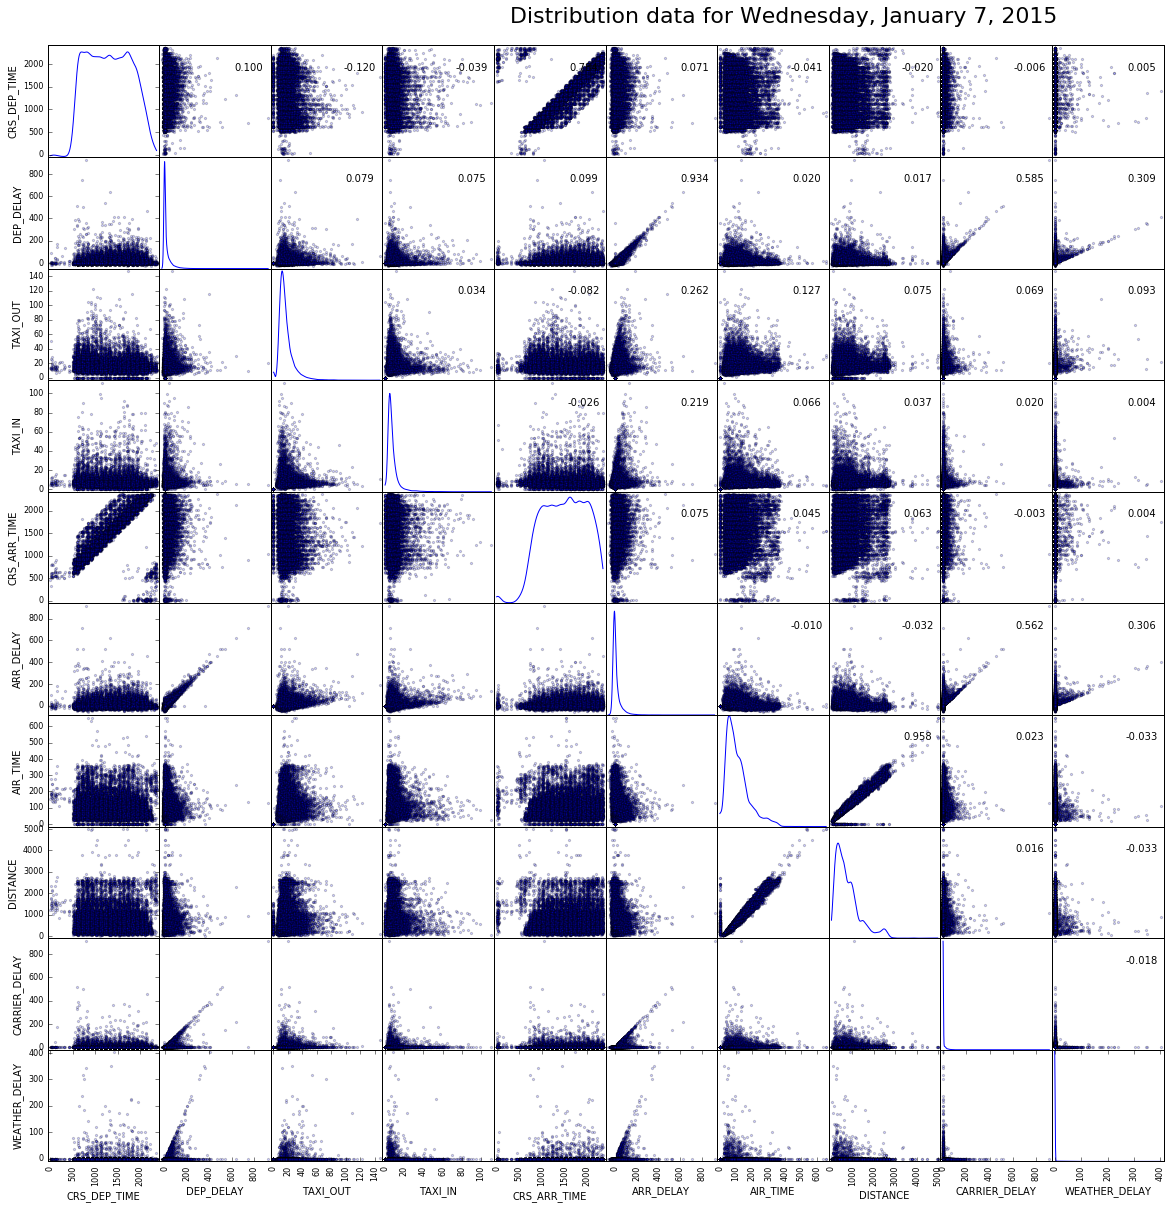

In [95]:
#plot scatter matrix
import matplotlib.pyplot as plt
#matplotlib.style.use('bmh')
#matplotlib.style.use('ggplot')
#matplotlib.style.use('grayscale')
import numpy as np
from pandas.tools.plotting import scatter_matrix

def plot_scatter_matrix(df_in):
    """"Plots a scatter matrix using pandas
    params:
    df_in = pandas frame to plot
    """
    fig = plt.figure(1)
    axes = scatter_matrix(df_in, alpha=0.2, figsize=(20, 20), diagonal='kde')

    corr = df_in.corr().as_matrix()
    for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
        axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

    plt.text(10,2.55, "Distribution data for Wednesday, January 7, 2015", fontsize=22, ha="right")    
    
    #save 
    plt.savefig('Flights_Fig1.png', dpi=300, bbox_inches="tight")
        
    plt.show()
    
plot_scatter_matrix(df_day)

## 2. So what's busier, the West or the East of the USA?


## 2A. Cut the USA in half.


As only US airports are included, you can divide the country using smaller as center line or larger as center line. The center point of the USA we can obtain from here http://www.kansastravel.org/geographicalcenter.htm
as
Latitude 39 degrees 50 minutes     Longitude 98 degrees 35 minute 
and then we just extend it to a line to north and south.
Therefore our cutoffs are:
if longitude < 98.35 = West
if longitude > 98.35 = East

We can ignore latitude (as we are interested in west, east), so we create four pandas frames which we query as and extract from:

1.arrivals_east
Query:
if DEST_lon > 98.35 = West
Extract:
-DAY_OF_MONTH
-CRS_ARR_TIME
-ARR_DELAY

2.arrivals_west
if DEST_lon < 98.35 = West
Extract:
-DAY_OF_MONTH
-CRS_ARR_TIME
-ARR_DELAY

3.departures_east
if ORIGIN_lon > 98.35 = West
Extract:
-DAY_OF_MONTH
-CRS_DEP_TIME
-DEP_DELAY

4.departures_west
if ORIGIN_lon < 98.35 = West
Extract:
-DAY_OF_MONTH
-CRS_DEP_TIME
-DEP_DELAY


A. We then sum all entries into days of months (and 24hrs) for both arrival and departures to get total arrival and departures over one month and over (4) weekdays.

B. We then do the same but average the delays to get the average delays over one month and over (4) weekdays.

#####  Load both halves into separate Pandas dataframes, so we can see where the arrival and departure action is

In [9]:
return_fields_departures = ["DAY_OF_MONTH", "CRS_DEP_TIME", "DEP_DELAY"]
return_fields_arrivals = ["DAY_OF_MONTH", "CRS_ARR_TIME", "ARR_DELAY"]

In [10]:
import pandas as pd

def departures_to_pandas(db, collection, return_fields, only_west = True):
    """"Queries to MongoDB for entries with an origin longitude smaller (West) or
    greater (east) than -98.35. Then expands the cursor and loads data 
    which is specfied in return_fields into a Pandas dataframe
    params:
    db = database from connection above
    collection_name = collection_name from above to add to 
    return_fields = list of fields to transfer into pandas
    only_west = True if looking for values lesser in long (west)
    """
    if only_west:
        cursor = db[collection_name].find(
            { "ORIGIN_lon": { '$lt': -98.35 } }
            ).batch_size(30) 
    else:
        cursor = db[collection_name].find(
            { "ORIGIN_lon": { '$gte': -98.35 } }
            ).batch_size(30) 
    
    return pd.DataFrame(list(cursor), columns = return_fields)

In [11]:
def arrivals_to_pandas(db, collection, return_fields, only_west = True):
    """"Queries to MongoDB for entries with an arrival longitude smaller (West) or
    greater (east) than -98.35. Then expands the cursor and loads data 
    which is specfied in return_fields into a Pandas dataframe
    params:
    db = database from connection above
    collection_name = collection_name from above to add to 
    return_fields = list of fields to transfer into pandas
    only_west = True if looking for values lesser in long (west)
    """
    if only_west:
        cursor = db[collection_name].find(
            { "DEST_lon": { '$lt': -98.35 } }
            ).batch_size(30) 
    else:
        cursor = db[collection_name].find(
            { "DEST_lon": { '$gte': -98.35 } }
            ).batch_size(30) 
    
    return pd.DataFrame(list(cursor),columns = return_fields)

In [12]:
#run above
df_temp = departures_to_pandas(db, collection_name, return_fields_departures, only_west = True)
#convert types to numeric and remove errors
df_temp = pd.to_numeric(df_temp, errors='coerce')
#parse to disk
df_temp.to_csv('df_departures_west.csv')

df_temp = departures_to_pandas(db, collection_name, return_fields_departures, only_west = False)
df_temp = pd.to_numeric(df_temp, errors='coerce')
df_temp.to_csv('df_departures_east.csv')

df_temp = arrivals_to_pandas(db, collection_name, return_fields_arrivals, only_west = True)
df_temp = pd.to_numeric(df_temp, errors='coerce')
df_temp.to_csv('df_arrivals_west.csv')

df_temp = arrivals_to_pandas(db, collection_name, return_fields_arrivals, only_west = False)
df_temp = pd.to_numeric(df_temp, errors='coerce')
df_temp.to_csv('df_arrivals_east.csv')

print df_temp.head()


   DAY_OF_MONTH  CRS_ARR_TIME  ARR_DELAY
0             1           510          0
1             1           510        109
2             1          1620         40
3             1          1720        133
4             1           705         24


## 2B. Create distributions and plot a bar plots of the mean departures and arrival for each day in one month (West vs East)

In [22]:
import numpy as np
def create_histogram(path_csv, mean_index):
    """"Takes a filename for a CSV file which gets parsed into a pandas
    frame. Then the rows gets grouped according to DAY_OF_MONTH values
    from which a mean and error is generated for DEP_DELAY and a count sum for 
    CRS_DEP_TIME. The group index, mean and sum get returned as new frame.
    params:
    path_csv = file path to csv file
    output: returns new frame
    """
    df = pd.read_csv(path_csv)
    df = df.drop('Unnamed: 0', 1)
    df_out=  df.groupby('DAY_OF_MONTH').agg([np.mean, np.std, np.sum]).sort([(mean_index, 'mean')])
    df_out.sort_index(inplace=True)
    new_header = ["Flights Mean", "Flights Error", 
                  "Flights Sum", "Delay Mean", "Delay Error", "Delay Sum"]
    df_out = df_out[1:] #take the data less the header row
    df_out.columns = new_header #set the header row as the df header
    return df_out, df

In [23]:
#create histogramms
hist_departures_west = create_histogram('df_departures_west.csv',"CRS_DEP_TIME")
hist_departures_east = create_histogram('df_departures_east.csv', "CRS_DEP_TIME")
hist_arrivals_west = create_histogram('df_arrivals_west.csv',"CRS_ARR_TIME")
hist_arrivals_east = create_histogram('df_arrivals_east.csv', "CRS_ARR_TIME")

print hist_arrivals_west[0].head()
print hist_departures_east[0].head()

              Flights Mean  Flights Error  Flights Sum  Delay Mean  \
DAY_OF_MONTH                                                         
1              1540.784457     484.605449      7355705    8.511102   
2              1516.545600     508.273030      8530569   11.874311   
3              1516.405939     501.580527      7915639   20.705747   
4              1527.809925     504.488694      8343370   22.740890   
5              1513.093588     497.221425      8164653   13.329689   

              Delay Error  Delay Sum  
DAY_OF_MONTH                          
1               34.771635      40632  
2               36.271999      66793  
3               46.730514     108084  
4               49.404617     124188  
5               44.755516      71927  
              Flights Mean  Flights Error  Flights Sum  Delay Mean  \
DAY_OF_MONTH                                                         
1              1376.429446     444.622785     12592953    7.885015   
2              1334.542718

C:\Users\Meyer\Documents\GitHub\VirtualEnvironments\mongoDB\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


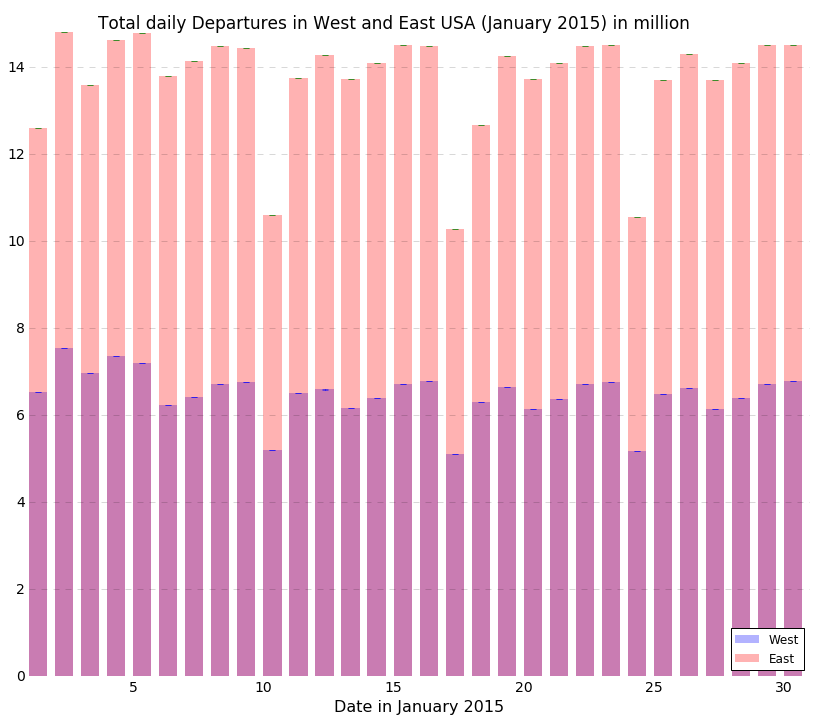

In [24]:
#plot departures as bar plots
import matplotlib  
import matplotlib.pyplot as plt 
from matplotlib import rcParams  
import matplotlib.image as mpimg

def plot_departures(departures_west, departures_east):
    """"plots the departure sums for west and east in one,
    the mean of delays in a second bar plot.
    params:
    hist_departures_west = hist_departures_west
    hist_departures_east = hist_departures_east
    path_csv = file path to csv file
    """
       
    departures_west['Flights Sum'] = departures_west['Flights Sum'].divide(1000000)
    departures_west['Flights Error'] = departures_west['Flights Error'].divide(1000000)
    departures_east['Flights Sum'] = departures_east['Flights Sum'].divide(1000000)
    departures_east['Flights Error'] = departures_east['Flights Error'].divide(1000000)
    
    
    #new subplot figure
    plt.figure(figsize=(14, 12))    
    axes = plt.subplot(111)   

    axes.spines["top"].set_visible(False)    
    axes.spines["bottom"].set_visible(False)    
    axes.spines["right"].set_visible(False)    
    axes.spines["left"].set_visible(False)   
    
    axes.get_xaxis().tick_bottom()    
    axes.get_yaxis().tick_left()   

    #plt.yticks(range(0, 91, 10), [str(x) + "%" for x in range(0, 91, 10)], fontsize=14)    
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)

    for y in range(0, 17, 2):    
        plt.plot(range(1, 32), [y] * len(range(1, 32)), "--", lw=0.5, color="black", alpha=0.3) 
       
    plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  
    
    plt.text(15, 14.9, "Total daily Departures in West and East USA (January 2015) in million", fontsize=17, ha="center")    
  
    #Departures
    title = 'West & East USA Departures'
    plt.bar(departures_west.index, departures_west['Flights Sum'], 0.7,
                 alpha=0.3,
                 lw=0,
                 color='b',
                 yerr=departures_west['Flights Error'].values,
                 label='West')
    
    plt.bar(departures_east.index, departures_east['Flights Sum'], 0.7,
                 alpha=0.3,
                 lw=0,
                 color='r',
                 yerr=departures_east['Flights Error'].values,
                 label='East')
    
    plt.ylim(0, 15.4)    
    plt.xlim(1, 31)  
    plt.xlabel("Date in January 2015", fontsize=16) 
    plt.legend(loc=4)
    
    #save 
    plt.savefig('Flights_Fig2.png', dpi=300, bbox_inches="tight")
   
    
plot_departures(hist_departures_west[0], hist_departures_east[0])

## 2C. Plot distributions of the delays for West and East USA for each day of one month.

[array([ 289.,  178.,   46., ...,    4.,   19.,   59.]), array([ 277.,  153.,   -2., ...,    0.,   -6.,    6.]), array([ 24.,   0.,   0., ...,  35.,  11.,  13.]), array([ 235.,  269.,   47., ...,    8.,   -2.,  102.]), array([  89.,  320.,   30., ...,    2.,   29.,   20.])]


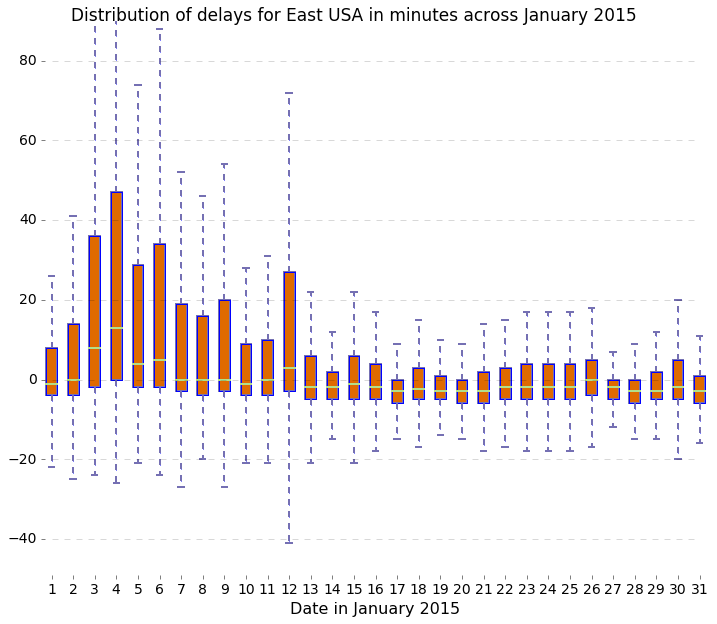

In [103]:
make_boxplot(hist_departures_east[1],
             "Distribution of delays for East USA in minutes across January 2015", '#df6a00')

[array([   0.,  108.,   33., ...,   14.,   14.,   -2.]), array([   0.,  119.,   -2., ...,   15.,   -1.,   -4.]), array([   0.,   67.,   -6., ...,    0.,   -1.,  208.]), array([ 37.,   2.,  18., ...,  91.,  10.,  19.]), array([ 4., -3.,  6., ..., -4., -6.,  8.])]


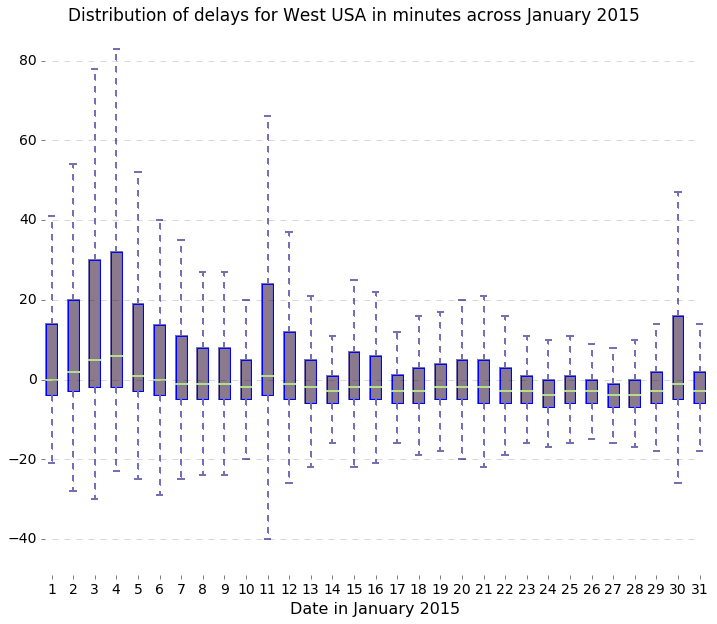

In [104]:
def make_boxplot(data_in, title, color):

    #extract days and delay
    delays= data_in[['DAY_OF_MONTH','DEP_DELAY']]
    #group by days
    groups = delays.groupby(delays.DAY_OF_MONTH)
    ##make a list with each day data
    data_to_plot = [groups.get_group(i)['DEP_DELAY'].values for i in range(1,32)]
    print data_to_plot[:5]
    
    # Create a figure instance
    fig = plt.figure(1, figsize=(12, 10))

    # Create an axes instance
    ax = fig.add_subplot(111)
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)   
    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()   
    
    # Create the boxplot
    bp = ax.boxplot(data_to_plot, showfliers=False)
 
    ## add patch_artist=True option to ax.boxplot() 
    ## to get fill color
    bp = ax.boxplot(data_to_plot, showfliers=False, patch_artist=True)

    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='#7570b3', linewidth=2)
        # change fill color
        box.set( facecolor = color)

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#b2df8a', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.1)

    ## Custom x-axis labels
    label = [str(i) for i in range(1,32)]
    
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)

    for y in range(-40, 100, 20):    
        plt.plot(range(1, 32), [y] * len(range(1, 32)), "--", lw=0.5, color="black", alpha=0.3) 
       
    plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  
    
    ## Remove top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.xlabel("Date in January 2015", fontsize=16) 
    plt.ylim(-50, 90)
    plt.text(15, 90,title , fontsize=17, ha="center")  
    #save 
    plt.savefig('Flights_Fig4.png', dpi=300, bbox_inches="tight")
  
make_boxplot(hist_departures_west[1],"Distribution of delays for West USA in minutes across January 2015", '#8B7A8B')

## 3. Which airline should I choose to quickly get out of the major aiports?

##### 3A. Query mongoDB and load into Pandas each airline and its taxi out and carrier delay times

In [32]:
return_fields_departures = ["CARRIER_STRING", "TAXI_OUT", "CARRIER_DELAY"]

In [35]:
def taxi_to_pandas_departures(db, collection, return_fields, city):
    """"Queries to MongoDB certain city codes and return delay and taxi times
    params:
    db = database from connection above
    collection_name = collection_name from above to add to 
    return_fields = list of fields to transfer into pandas
    city = City code to retrieve
    """
    cursor = db[collection_name].find(
            { "ORIGIN": city }
            ).batch_size(30) 
       
    return pd.DataFrame(list(cursor),columns = return_fields)

#df = taxi_to_pandas_departures(db, collection, return_fields_departures, ATL)

##### 3B. Group the data into airlines within Pandas

In [36]:
#group all fields by city and bin in days calculating the mean and errors for taxi and delay
def create_airport_histogram(path_csv, sort_field):
    """"Takes a filename for a CSV file which gets parsed into a pandas
    frame. Then the rows gets grouped according to DAY_OF_MONTH values
    from which a mean is generated for DEP_DELAY and a count sum for 
    CRS_DEP_TIME. The group index, mean and sum get returned as new frame.
    params:
    path_csv = file path to csv file
    output: returns new frame
    """
    df = pd.read_csv(path_csv)
    df = df.drop('Unnamed: 0', 1)
    df['CARRIER_STRING'] = df['CARRIER_STRING'].str.replace(r'US Airways.+', 'US Airways Inc.')
    df_out = df.groupby('CARRIER_STRING').agg([np.mean, np.std]).sort(
        [(sort_field, 'mean')])
    new_header = ["Taxi Mean", "Taxi Error", 
                  "Carrier Mean", "Carrier Error"]
    df_out = df_out[1:] #take the data less the header row
    df_out.columns = new_header #set the header row as the df header
    return df_out

In [37]:
ATL_airlines_taxi = create_airport_histogram('df_delays_departures_ATL.csv', 'TAXI_OUT')
ATL_airlines_delay  = create_airport_histogram('df_delays_departures_ATL.csv', 'CARRIER_DELAY')
print ATL_airlines_taxi.head()
print ATL_airlines_delay.head()

LAX_airlines_taxi = create_airport_histogram('df_delays_departures_LAX.csv', 'TAXI_OUT')
LAX_airlines_delay = create_airport_histogram('df_delays_departures_LAX.csv', 'CARRIER_DELAY')

ORD_airlines_taxi = create_airport_histogram('df_delays_departures_ORD.csv', 'TAXI_OUT')
ORD_airlines_delay = create_airport_histogram('df_delays_departures_ORD.csv', 'CARRIER_DELAY')

DFW_airlines_taxi = create_airport_histogram('df_delays_departures_DFW.csv', 'TAXI_OUT')
DFW_airlines_delay = create_airport_histogram('df_delays_departures_DFW.csv', 'CARRIER_DELAY')

JFK_airlines_taxi = create_airport_histogram('df_delays_departures_JFK.csv', 'TAXI_OUT')
JFK_airlines_delay = create_airport_histogram('df_delays_departures_JFK.csv', 'CARRIER_DELAY')

                             Taxi Mean  Taxi Error  Carrier Mean  \
CARRIER_STRING                                                     
Southwest Airlines Co.       15.120544    5.911008      2.960272   
Alaska Airlines Inc.         15.645161    5.282350      2.129032   
United Air Lines Inc.        15.885845    7.085373      1.630137   
Frontier Airlines Inc.       15.973404    5.759376      4.547872   
Atlantic Southeast Airlines  16.443979    6.419383      6.746624   

                             Carrier Error  
CARRIER_STRING                              
Southwest Airlines Co.           12.009955  
Alaska Airlines Inc.              7.486619  
United Air Lines Inc.             9.755507  
Frontier Airlines Inc.           14.208638  
Atlantic Southeast Airlines      26.119073  
                        Taxi Mean  Taxi Error  Carrier Mean  Carrier Error
CARRIER_STRING                                                            
United Air Lines Inc.   15.885845    7.085373      1.63013

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


##### 3C. Plot the worst 10 airlines in terms of carrier delays and taxi times

In [109]:
def plot_airlines(textIn, item, item_error, label1, label2, label3, label4, label5,
              df_in1, df_in2, df_in3, df_in4, df_in5):
    """"plots the departure sums for west and east in one,
    the mean of delays in a second bar plot.
    params:
    hist_departures_west = hist_departures_west
    hist_departures_east = hist_departures_east
    path_csv = file path to csv file
    """
    #new subplot figure
    
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14, 10))
    plt.text(19, 41, textIn, fontsize=17, ha="center")    
  
    width = 0.5
    df1 = pd.DataFrame(dict(graph=df_in1.index, n=df_in1[item])) 
    ind = np.arange(len(df1))
    axes[0].barh(ind, df1.n, width, color='green', edgecolor = 'white', alpha=0.4, label=label1,
                xerr=df_in1[item_error].values, error_kw=dict(ecolor='lightgray', lw=1, capsize=1, capthick=1))
    axes[0].set(yticks=ind + width, yticklabels=df1.graph, ylim=[2*width - 1, len(df1)])
    axes[0].tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  
    axes[0].spines["top"].set_visible(False)    
    axes[0].spines["bottom"].set_visible(False)    
    axes[0].spines["right"].set_visible(False)    
    axes[0].spines["left"].set_visible(False) 
    axes[0].legend(loc=4, frameon=False)
    
    df1 = pd.DataFrame(dict(graph=df_in2.index, n=df_in2[item])) 
    ind = np.arange(len(df1))
    axes[1].barh(ind, df1.n, width, color='red', edgecolor = 'white', alpha=0.4, label=label2,
                xerr=df_in2[item_error].values, error_kw=dict(ecolor='lightgray', lw=1, capsize=1, capthick=1))
    axes[1].set(yticks=ind + width, yticklabels=df1.graph, ylim=[2*width - 1, len(df1)])
    axes[1].tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  
    axes[1].spines["top"].set_visible(False)    
    axes[1].spines["bottom"].set_visible(False)    
    axes[1].spines["right"].set_visible(False)    
    axes[1].spines["left"].set_visible(False) 
    axes[1].legend(loc=4, frameon=False)
    
    df1 = pd.DataFrame(dict(graph=df_in3.index, n=df_in3[item])) 
    ind = np.arange(len(df1))
    axes[2].barh(ind, df1.n, width, color='orange', edgecolor = 'white', alpha=0.4, label=label3,
                xerr=df_in3[item_error].values, error_kw=dict(ecolor='lightgray', lw=1, capsize=1, capthick=1))
    axes[2].set(yticks=ind + width, yticklabels=df1.graph, ylim=[2*width - 1, len(df1)])
    axes[2].tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  
    axes[2].spines["top"].set_visible(False)    
    axes[2].spines["bottom"].set_visible(False)    
    axes[2].spines["right"].set_visible(False)    
    axes[2].spines["left"].set_visible(False) 
    axes[2].legend(loc=4, frameon=False)
   
    df1 = pd.DataFrame(dict(graph=df_in4.index, n=df_in4[item])) 
    ind = np.arange(len(df1))
    axes[3].barh(ind, df1.n, width, color='blue', edgecolor = 'white', alpha=0.4, label=label4,
                xerr=df_in4[item_error].values, error_kw=dict(ecolor='lightgray', lw=1, capsize=1, capthick=1))
    axes[3].set(yticks=ind + width, yticklabels=df1.graph, ylim=[2*width - 1, len(df1)])
    axes[3].tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  
    axes[3].spines["top"].set_visible(False)    
    axes[3].spines["bottom"].set_visible(False)    
    axes[3].spines["right"].set_visible(False)    
    axes[3].spines["left"].set_visible(False)  
    axes[3].legend(loc=4, frameon=False)
    
    df1 = pd.DataFrame(dict(graph=df_in5.index, n=df_in5[item])) 
    ind = np.arange(len(df1))
    axes[4].barh(ind, df1.n, width, color='black', edgecolor = 'white', alpha=0.4, label=label5,
                xerr=df_in5[item_error].values, error_kw=dict(ecolor='lightgray', lw=1, capsize=1, capthick=1))
    axes[4].set(yticks=ind + width, yticklabels=df1.graph, ylim=[2*width - 1, len(df1)])
    axes[4].tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  
    axes[4].spines["top"].set_visible(False)    
    axes[4].spines["bottom"].set_visible(False)    
    axes[4].spines["right"].set_visible(False)    
    axes[4].spines["left"].set_visible(False)   
    plt.xlabel("Minutes", fontsize=16) 
    axes[4].legend(loc=4, frameon=False)
    #save 
    plt.savefig('Flights_Fig6.png', dpi=300, bbox_inches="tight")
    #plt.tight_layout()
    #plt.savefig("normalvars.png", dpi=150)



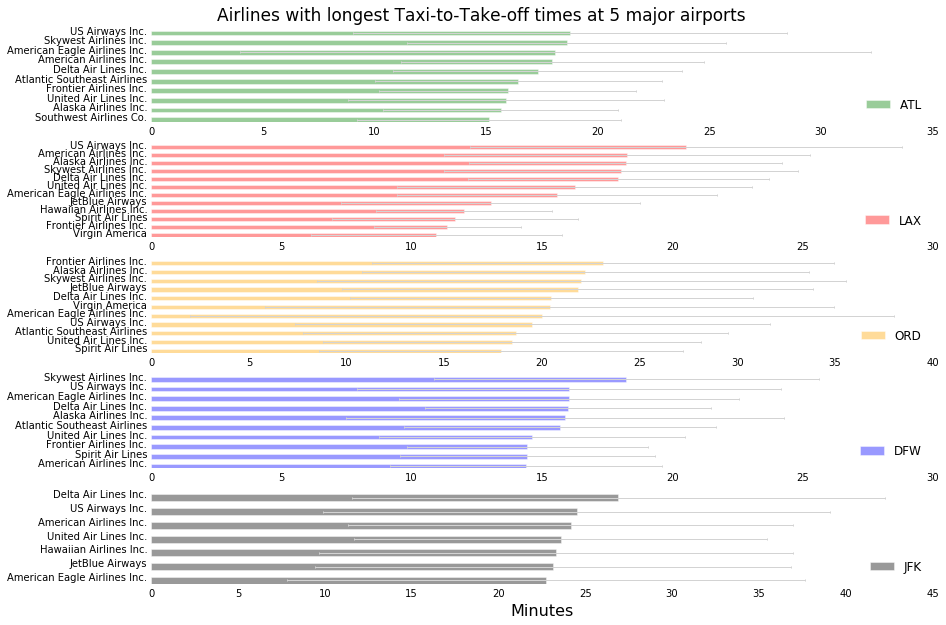

In [110]:
plot_airlines('Airlines with longest Taxi-to-Take-off times at 5 major airports', "Taxi Mean", "Taxi Error", 'ATL', 'LAX',
          'ORD', 'DFW', 'JFK',
          ATL_airlines_taxi, LAX_airlines_taxi, ORD_airlines_taxi, 
          DFW_airlines_taxi,JFK_airlines_taxi)


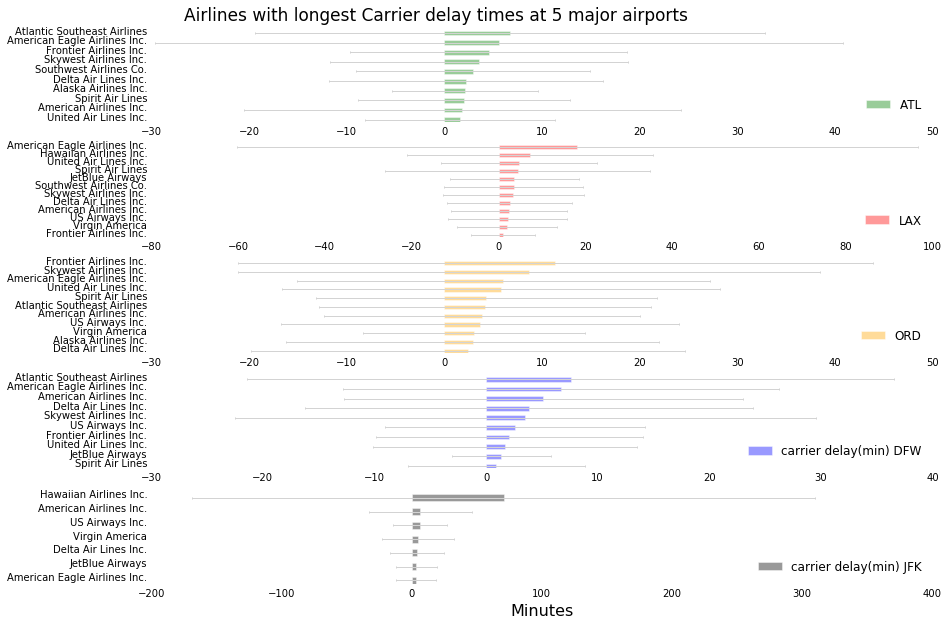

In [108]:

plot_airlines('Airlines with longest Carrier delay times at 5 major airports', "Carrier Mean", "Carrier Error",'ATL', 'LAX',
          'ORD', 'carrier delay(min) DFW', 'carrier delay(min) JFK',
          ATL_airlines_delay, LAX_airlines_delay, ORD_airlines_delay, 
          DFW_airlines_delay,JFK_airlines_delay)

## 4. Where in the USA are the worst weather delays that affect my flights?

##### 4A. query mongoDB and load into Pandas the weather delays and corresponding coordinates for each departure.

In [8]:
return_fields_weather = ["WEATHER_DELAY", "ORIGIN_lon", "ORIGIN_lat"]

In [14]:
def weather_to_pandas_departures(db, collection, return_fields):
    """"Queries to MongoDB for entries with an arrival longitude smaller (West) or
    greater (east) than -98.35. Then expands the cursor and loads data 
    which is specfied in return_fields into a Pandas dataframe
    params:
    db = database from connection above
    collection_name = collection_name from above to add to 
    return_fields = list of fields to transfer into pandas
    only_west = True if looking for values lesser in long (west)
    """
    cursor = db[collection_name].find(
            { "WEATHER_DELAY": { '$gt': "0" } }
            ).batch_size(30)   
    return pd.DataFrame(list(cursor),columns = return_fields)

In [15]:
#df_temp = weather_to_pandas_departures(db, collection_name, return_fields_weather)
#df_temp = pd.to_numeric(df_temp, errors='coerce')
#df_temp.to_csv('df_weather_delays.csv')
#load saved coords
df_temp = pd.read_csv('df_weather_delays.csv')
df_temp = df_temp.drop('Unnamed: 0', 1)

print df_temp.head()

   WEATHER_DELAY  ORIGIN_lon  ORIGIN_lat
0              3    -97.0372   32.895951
1              2    -97.0372   32.895951
2              8    -97.0372   32.895951
3            102    -97.0372   32.895951
4              7    -97.0372   32.895951


#### 4B. plot on map each incident of weather delay with the size of the circle matching delay time
   

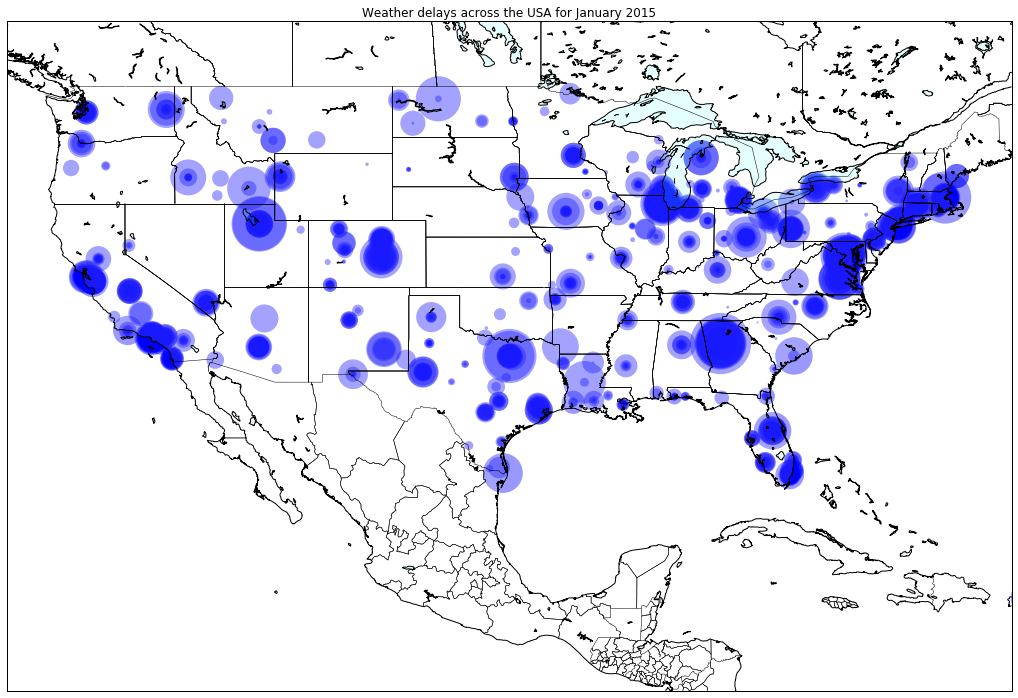

In [21]:

#plot circles for each delay, the size matching the magnitude
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap

def plot_weather(longitude, latitude, df_weather):
    figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 18))

    m = Basemap(
                ax=axes,
                projection='cyl',
                lon_0=longitude, lat_0=latitude,
                llcrnrlat=latitude - 20.0, urcrnrlat=latitude + 20.0,
                llcrnrlon=longitude - 30.0, urcrnrlon=longitude + 30.0,
                resolution='i'
                )

   
    m.fillcontinents(color='white', alpha = 0.1,lake_color='aqua')

    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    m.drawstates()
    
    lons = df_weather.ORIGIN_lon
    lats = df_weather.ORIGIN_lat
 
    x, y = m(df_weather.ORIGIN_lon, df_weather.ORIGIN_lat)
   
    s = [int(row)*4 for row in df_weather['WEATHER_DELAY']]
    plt.scatter(x, y, s=s, alpha=0.4, edgecolor='none')
    plt.title('Weather delays across the USA for January 2015')
    #plt.savefig('Flights_Fig7.png', dpi=300, bbox_inches="tight")
    plt.show()
    
plot_weather(-97.0372,32.895951, df_temp)   
    

 #### 4C. plot a density hex map with the color matching the number of delays per hex bin area

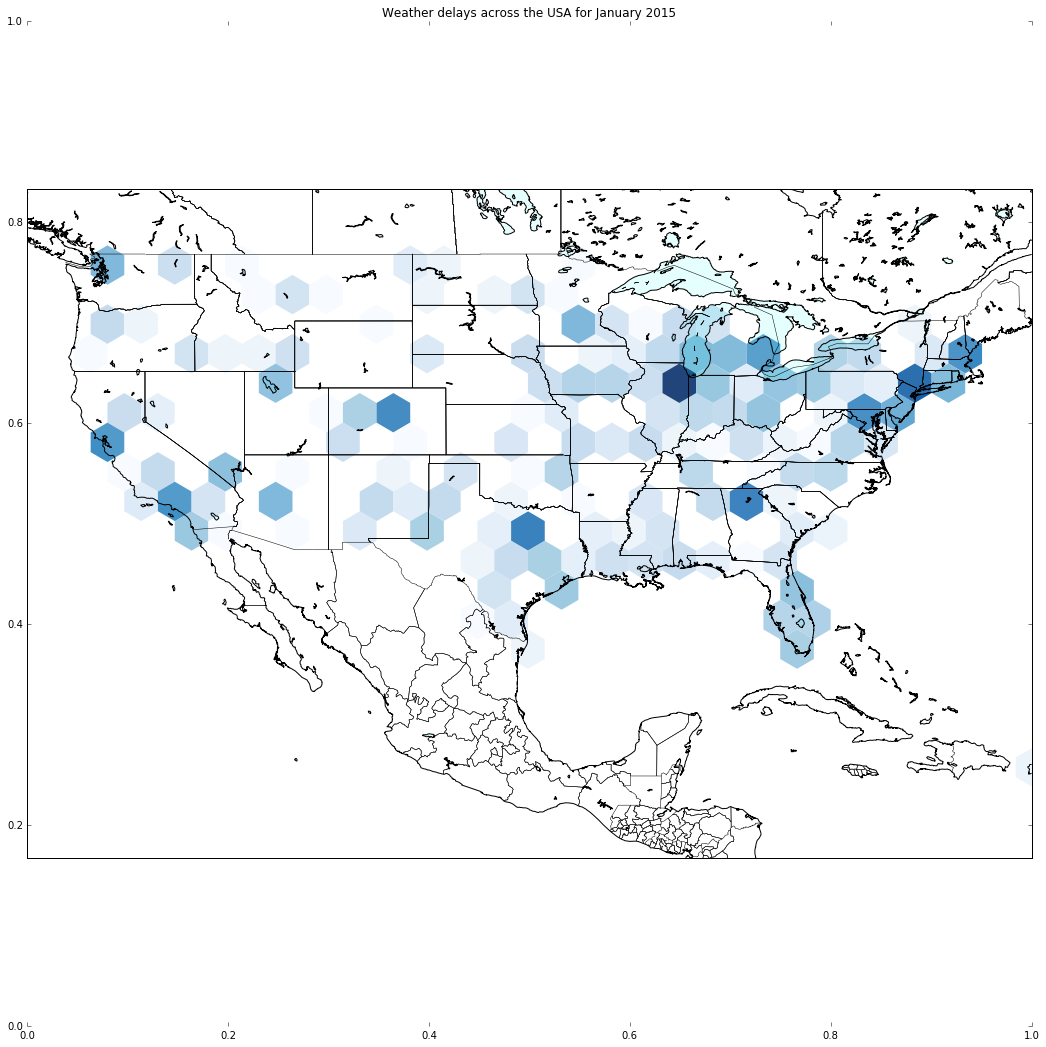

In [18]:

from numpy.random import uniform

def plot_hex_delays(df_in):
    longitude =-97.0372
    latitude= 32.895951

    figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 18))

    m = Basemap(
                    ax=axes,
                    projection='cyl',
                    lon_0=-97.0372, lat_0=32.895951,
                    llcrnrlat=latitude - 20.0, urcrnrlat=latitude + 20.0,
                    llcrnrlon=longitude - 30.0, urcrnrlon=longitude + 30.0,
                    resolution='i'
                    )

    m.fillcontinents(color='white', alpha = 0.1,lake_color='aqua')

    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    m.drawstates()
    
    figwidth = 14

    ax = figure.add_subplot(111, axisbg='w', frame_on=False)

    # The number of hexbins you want in the x-direction
    numhexbins = 50
    hx = m.hexbin(
        np.array([x for x in df_in.ORIGIN_lon]),
        np.array([y for y in df_in.ORIGIN_lat]),
        gridsize=(numhexbins, int(numhexbins*0.3)), #critical to get regular hexagon, must stretch to map dimensions
        bins='log', mincnt=1, edgecolor='none', alpha=1.,
        cmap=plt.get_cmap('Blues'))
 
    plt.title('Weather delays across the USA for January 2015')
    plt.savefig('Flights_Fig8.png', dpi=300, bbox_inches="tight")
    plt.show()
    
    
plot_hex_delays(df_temp)

##  5. What would be an ideal route if I want to collect my own data visiting every single airport?

#### 5A. Query mongoDB for the airport coordinates and add all airport distances into a set

In [45]:
return_fields = ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID','ORIGIN_lon', 'ORIGIN_lat', 'DEST_lon', 'DEST_lat']

In [46]:
#que mongo to get all airport coordinates used in dataset
def airport_coords_to_pandas(db, collection, return_fields):
    """"Queries to MongoDB for entries with an arrival longitude smaller (West) or
    greater (east) than -98.35. Then expands the cursor and loads data 
    which is specfied in return_fields into a Pandas dataframe
    params:
    db = database from connection above
    collection_name = collection_name from above to add to 
    return_fields = list of fields to transfer into pandas
    only_west = True if looking for values lesser in long (west)
    """
    cursor = db[collection_name].find(
            { "ORIGIN_lon": { '$lt': 0 } }
            ).batch_size(30)   
    return pd.DataFrame(list(cursor),columns = return_fields)

In [47]:
#save airport coords
collection_name = "flights_januar15"
#df_ports = airport_coords_to_pandas(db, collection_name, return_fields)
#df_ports.to_csv('df_ports_coords.csv')
#print df_ports.head()

In [27]:
#load saved coords
df = pd.read_csv('df_ports_coords.csv')
df = df.drop('Unnamed: 0', 1)
print df.head()

   ORIGIN_AIRPORT_ID  DEST_AIRPORT_ID  ORIGIN_lon  ORIGIN_lat    DEST_lon  \
0              11298            12173  -97.037200   32.895951 -157.922407   
1              11298            13830  -97.037200   32.895951 -156.430458   
2              12173            11298 -157.922407   21.318691  -97.037200   
3              11298            14771  -97.037200   32.895951 -122.374843   
4              14771            11298 -122.374843   37.619002  -97.037200   

    DEST_lat  
0  21.318691  
1  20.898650  
2  32.895951  
3  37.619002  
4  32.895951  


In [28]:
#make a df containing all airports and coordinates once
def make_set_with_coords(df):
    #include all departure airports
    #group by unique departures, then average over the coordinates of departures
    #those should not change (error =0). Keep all those, delete rest
    df_origin=  df.groupby('ORIGIN_AIRPORT_ID').agg([np.mean, np.std])
    df_origin.sort_index(inplace=True)
    df_origin = df_origin.dropna()
    #print df_origin.head()
    #delete all others
    df_origin.drop(df_origin.columns[[0, 1, 3, 5, 6, 7, 8, 9]], axis=1, inplace=True)
    df_origin = df_origin.reset_index()
    df_origin = pd.DataFrame(df_origin.values);
    #print df_origin.head()
    #print df_origin.shape
    #now do the same for the destination aiports (group, extract the ones with 0 error)
    df_dest=  df.groupby('DEST_AIRPORT_ID').agg([np.mean, np.std])
    df_dest.sort_index(inplace=True)
    df_dest = df_dest.dropna()
    #print df_origin.head()
    df_dest.drop(df_dest.columns[[0, 1, 2, 3, 4, 5, 7, 9]], axis=1, inplace=True)
    df_dest = df_dest.reset_index()
    df_dest = pd.DataFrame(df_dest.values);
    #print df_dest.head()
    #print df_dest.shape
    df_all = df_origin.append(df_dest, ignore_index=True)
    #print df_all.head()
    #print df_all.shape
    #now combine both sets (origin and departure) and also now group by airport to keep 
    #each exactly once.
    df_out=  df_all.groupby(0).agg([np.mean, np.std])
    df_out.sort_index(inplace=True)
    #delete all others
    df_out.drop(df_out.columns[[ 1, 3]], axis=1, inplace=True)
    df_out = df_out.reset_index()
    df_out = pd.DataFrame(df_out.values);
    print df_out.head()
    print df_out.shape
    return df_out

df_set_of_ports = make_set_with_coords(df)

       0           1          2
0  10135  -75.440402  40.652363
1  10136  -99.681897  32.411320
2  10140 -106.609194  35.040222
3  10141  -98.421833  45.449056
4  10146  -84.194473  31.535515
(309, 3)


#### 5B. Get each airport once and calculate all possible combinations and distances

In [29]:
#function to calculate distance between two points
from math import sin, cos, sqrt, atan2, radians, isnan

def calculate_distance(lon1, lat1, lon2, lat2):
    # approximate radius of earth in km
    R = 6373.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    diff_lon = lon2 - lon1
    diff_lat = lat2 - lat1

    a = sin(diff_lat / 2)**2 + cos(lat1) * cos(lat2) * sin(diff_lon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    if isnan(distance):
        return 0
    else:
        return int(distance)

In [30]:
#create a matrix of all possible distances between all ports (size*size)
def make_distance_martrix(df1):
    ports_connections = set()
    ports_connections_distances = {}
    #go through set once
    for i, row_i in df1.iterrows():
        #go through same set again
        for y, row_y in df1.iterrows():
            if i>0:
                if y>0:
                    #only proceed if not yet added that combination
                    if (row_i[0], row_y[0]) not in ports_connections:
                        try:
                            #use the stored coordinates to calculate distance with function above
                            ports_connections_distances[frozenset([row_i[0], row_y[0]])] = calculate_distance(
                                                row_i[1], row_i[2], row_y[1], row_y[2])
                            #add the current connection to ports (port1, port2)
                            ports_connections.update([row_i[0], row_y[0]])
                            
                           
                        except KeyError:
                            print(
                                "Could not convert entry %s" %len(ports_connections) 
                                )
    return ports_connections, ports_connections_distances

In [31]:
ports, port_distances = make_distance_martrix(df_set_of_ports)
print list(ports)[:5]
print len(ports)

[14696.0, 10754.0, 11267.0, 13830.0, 13230.0]
308


In [32]:
print len(port_distances)
#print port_distances

47586


#### 5C. Use a genetic algorithm to calculate and optimize a path with the minimal distance between all airports

In [33]:
import random
#adatped from:
#http://nbviewer.jupyter.org/github/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/optimal-road-trip/Computing%20the%20optimal%20road%20trip%20across%20the%20U.S..ipynb

def compute_fitness(solution):
    """
        This function returns the total distance traveled on the current road trip.
        
        The genetic algorithm will favor road trips that have shorter
        total distances traveled.
    """
    
    solution_fitness = 0.0
    
    for index in range(len(solution)):
        port1 = solution[index - 1]
        port2 = solution[index]
        solution_fitness += port_distances[frozenset([port1, port2])]
        
    return solution_fitness

def generate_random_agent():
    """
        Creates a random road trip from the waypoints.
    """
    
    new_random_agent = list(ports)
    random.shuffle(new_random_agent)
    return tuple(new_random_agent)

def mutate_agent(agent_genome, max_mutations=3):
    """
        Applies 1 - `max_mutations` point mutations to the given road trip.
        
        A point mutation swaps the order of two waypoints in the road trip.
    """
    
    agent_genome = list(agent_genome)
    num_mutations = random.randint(1, max_mutations)
    
    for mutation in range(num_mutations):
        swap_index1 = random.randint(0, len(agent_genome) - 1)
        swap_index2 = swap_index1

        while swap_index1 == swap_index2:
            swap_index2 = random.randint(0, len(agent_genome) - 1)

        agent_genome[swap_index1], agent_genome[swap_index2] = agent_genome[swap_index2], agent_genome[swap_index1]
            
    return tuple(agent_genome)

def shuffle_mutation(agent_genome):
    """
        Applies a single shuffle mutation to the given road trip.
        
        A shuffle mutation takes a random sub-section of the road trip
        and moves it to another location in the road trip.
    """
    
    agent_genome = list(agent_genome)
    
    start_index = random.randint(0, len(agent_genome) - 1)
    length = random.randint(2, 20)
    
    genome_subset = agent_genome[start_index:start_index + length]
    agent_genome = agent_genome[:start_index] + agent_genome[start_index + length:]
    
    insert_index = random.randint(0, len(agent_genome) + len(genome_subset) - 1)
    agent_genome = agent_genome[:insert_index] + genome_subset + agent_genome[insert_index:]
    
    return tuple(agent_genome)

def generate_random_population(pop_size):
    """
        Generates a list with `pop_size` number of random road trips.
    """
    
    random_population = []
    for agent in range(pop_size):
        random_population.append(generate_random_agent())
    return random_population
    
def run_genetic_algorithm(generations=5000, population_size=100):
    """
        The core of the Genetic Algorithm.
        
        `generations` and `population_size` must be a multiple of 10.
    """
    flight_paths_out = []
    model_performance = []
    num_generations = []
    population_subset_size = int(population_size / 10.)
    generations_10pct = int(generations / 10.)
    
    # Create a random population of `population_size` number of solutions.
    population = generate_random_population(population_size)

    # For `generations` number of repetitions...
    for generation in range(generations):
        
        # Compute the fitness of the entire current population
        population_fitness = {}

        for agent_genome in population:
            if agent_genome in population_fitness:
                continue

            population_fitness[agent_genome] = compute_fitness(agent_genome)

        # Take the top 10% shortest road trips and produce offspring each from them
        new_population = []
        for rank, agent_genome in enumerate(sorted(population_fitness,
                                                   key=population_fitness.get)[:population_subset_size]):
            
            if (generation % generations_10pct == 0 or generation == generations - 1) and rank == 0:
                print("Generation %d best: %d | Unique genomes: %d" % (generation,
                                                                       population_fitness[agent_genome],
                                                                       len(population_fitness)))
                print(agent_genome)
                print("")
                flight_paths_out.append(agent_genome)
                model_performance.append(population_fitness[agent_genome])
                num_generations.append(generation)
                
            # Create 1 exact copy of each of the top road trips
            new_population.append(agent_genome)

            # Create 2 offspring with 1-3 point mutations
            for offspring in range(2):
                new_population.append(mutate_agent(agent_genome, 3))
                
            # Create 7 offspring with a single shuffle mutation
            for offspring in range(7):
                new_population.append(shuffle_mutation(agent_genome))

        # Replace the old population with the new population of offspring 
        for i in range(len(population))[::-1]:
            del population[i]

        population = new_population
    return flight_paths_out, population_fitness[agent_genome], model_performance, num_generations

In [34]:
flight_paths, shortest_trip, model_performance, generations = run_genetic_algorithm(
    generations=10000, population_size=100)

Generation 0 best: 659103 | Unique genomes: 100
(11540.0, 15376.0, 15380.0, 14730.0, 13076.0, 11980.0, 13459.0, 13256.0, 15411.0, 13871.0, 10874.0, 10372.0, 14960.0, 12891.0, 15070.0, 13029.0, 10739.0, 11413.0, 14027.0, 10136.0, 13232.0, 15249.0, 12335.0, 15841.0, 12173.0, 10926.0, 12511.0, 10141.0, 14256.0, 13264.0, 12156.0, 12892.0, 15370.0, 11003.0, 10165.0, 14321.0, 15389.0, 14107.0, 15041.0, 14574.0, 10333.0, 14109.0, 13851.0, 13061.0, 11193.0, 13367.0, 10821.0, 10685.0, 14098.0, 10731.0, 12177.0, 12945.0, 13577.0, 13204.0, 13931.0, 15323.0, 10631.0, 10431.0, 13344.0, 11721.0, 13296.0, 12264.0, 11577.0, 13485.0, 10627.0, 15016.0, 11953.0, 12884.0, 12129.0, 11274.0, 10747.0, 13795.0, 14150.0, 11617.0, 14520.0, 11252.0, 10561.0, 12448.0, 11587.0, 14122.0, 15582.0, 10469.0, 11503.0, 13873.0, 10785.0, 14254.0, 12954.0, 14711.0, 12217.0, 11337.0, 11203.0, 14487.0, 10713.0, 13198.0, 10185.0, 10434.0, 12206.0, 11067.0, 12191.0, 10728.0, 10779.0, 10551.0, 12478.0, 12451.0, 11638.0, 11057.

In [35]:
print flight_paths[1]

(12884.0, 13232.0, 11274.0, 12511.0, 14674.0, 13502.0, 11921.0, 14288.0, 11092.0, 15582.0, 14113.0, 15389.0, 10666.0, 14747.0, 13127.0, 12441.0, 12094.0, 11109.0, 15401.0, 10728.0, 13244.0, 12992.0, 15016.0, 14108.0, 11267.0, 10693.0, 11067.0, 13367.0, 12339.0, 11612.0, 14730.0, 13198.0, 11423.0, 13487.0, 10268.0, 11203.0, 10631.0, 10739.0, 15008.0, 11003.0, 11433.0, 11986.0, 11721.0, 11823.0, 10469.0, 11042.0, 12391.0, 10529.0, 10990.0, 13931.0, 13795.0, 13577.0, 11641.0, 11995.0, 12323.0, 15024.0, 10732.0, 11624.0, 12451.0, 11252.0, 13360.0, 10994.0, 12217.0, 14783.0, 10185.0, 15919.0, 12007.0, 11150.0, 10397.0, 11057.0, 10980.0, 11996.0, 14492.0, 11146.0, 12264.0, 12898.0, 15096.0, 11617.0, 14098.0, 10821.0, 10792.0, 12265.0, 14576.0, 14321.0, 13933.0, 10721.0, 10785.0, 10434.0, 11278.0, 15356.0, 11618.0, 13296.0, 15070.0, 14307.0, 12197.0, 12953.0, 10257.0, 12478.0, 10158.0, 14100.0, 11537.0, 12320.0, 14524.0, 10208.0, 10731.0, 15304.0, 14843.0, 15027.0, 14254.0, 14986.0, 14635.0, 

In [36]:
# now we can reorder the df with all the ports and coordinates we made above to each path
def reorder_port_coords(df_port_set_single, order_list):
    #move ports to index
    df_port_set = df_port_set_single.set_index(0)
    #generate list of ints for index
    order_list = [int(i) for i in order_list]
    #reindex and format
    df_port_set = df_port_set.reindex(order_list)
    df_port_set = df_port_set.reset_index()
    df_port_set = df_port_set.drop(0,axis=1)
    return df_port_set

def batch_reorder_port_coords(df_port_set, order_list):
    df_all = pd.DataFrame()
    for row in order_list:
        current_df = reorder_port_coords(df_set_of_ports, row)
        df_all = pd.concat([df_all, current_df], axis=1)
    return df_all

df_all_paths_for_plot =  batch_reorder_port_coords(df_set_of_ports, flight_paths)


In [37]:
print df_all_paths_for_plot.head()
print model_performance
print generations

            1          2           1          2           1          2  \
0 -106.377806  31.806667  -84.587358  42.778700 -112.008056  33.434167   
1 -110.941028  32.116083  -87.752424  41.785983 -116.506253  33.829216   
2  -85.582235  44.741445  -90.709167  42.402959 -111.671218  35.138455   
3  -85.736000  38.174389  -94.498268  37.151814 -106.609194  35.040222   
4  -91.256538  43.879380 -106.088139  35.616778 -104.530556  33.301556   

           1          2          1          2    ...              1  \
0 -90.507539  41.448526 -89.693306  40.664243    ...     -90.507539   
1 -88.278056  40.039250 -86.294384  39.717329    ...     -89.693306   
2 -84.662172  39.046143 -88.278056  40.039250    ...     -86.294384   
3 -84.219375  39.902376 -84.662172  39.046143    ...     -86.238223   
4 -84.587358  42.778700 -84.219375  39.902376    ...     -85.582235   

           2          1          2          1          2          1  \
0  41.448526 -89.976667  35.042417 -95.339722  29.980472 

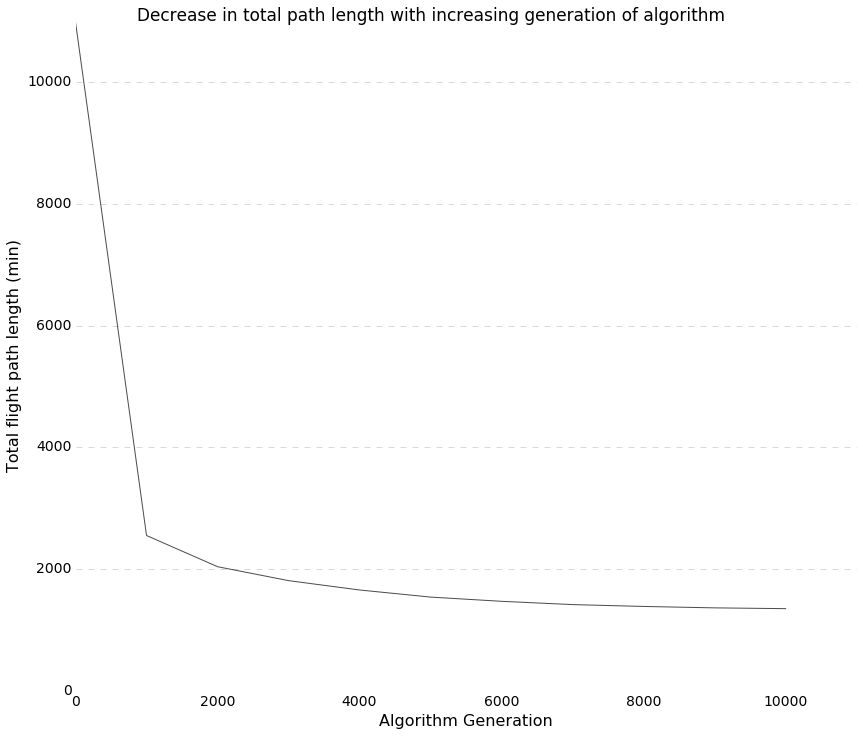

In [41]:
#plot the performance of the genetic algorithm in optimizing total distance
def plot_path_model_performance(model_performance_in, generations_in):
    """"plots the departure sums for west and east in one,
    the mean of delays in a second bar plot.
    params:
    hist_departures_west = hist_departures_west
    hist_departures_east = hist_departures_east
    path_csv = file path to csv file
    """
    model_performance_in = [x/60 for x in model_performance_in]
    #new subplot figure
    plt.figure(figsize=(14, 12))    
    axes = plt.subplot(111)   

    axes.spines["top"].set_visible(False)    
    axes.spines["bottom"].set_visible(False)    
    axes.spines["right"].set_visible(False)    
    axes.spines["left"].set_visible(False)   
    
    axes.get_xaxis().tick_bottom()    
    axes.get_yaxis().tick_left()   

    #plt.yticks(range(0, 91, 10), [str(x) + "%" for x in range(0, 91, 10)], fontsize=14)    
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)

    for y in range(0, 12000, 2000):    
        plt.plot((1, 20000), [y] * len((1, 20000)), "--", lw=0.5, color="black", alpha=0.3) 
       
    plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  
    
    plt.text(5000, 11000, "Decrease in total path length with increasing generation of algorithm", fontsize=17, ha="center")    
  
     
    plt.plot(generations_in,
             model_performance_in, lw=1, color="black", alpha=0.7)  
    
    
    plt.ylim(0, 11000)    
    plt.xlim(1, 11000)  
    plt.xlabel("Algorithm Generation", fontsize=16) 
    plt.ylabel("Total flight path length (min)", fontsize=16) 

    
    #save   
    plt.savefig("Flight_Fig10.png", bbox_inches="tight") 
    
plot_path_model_performance(model_performance, generations)

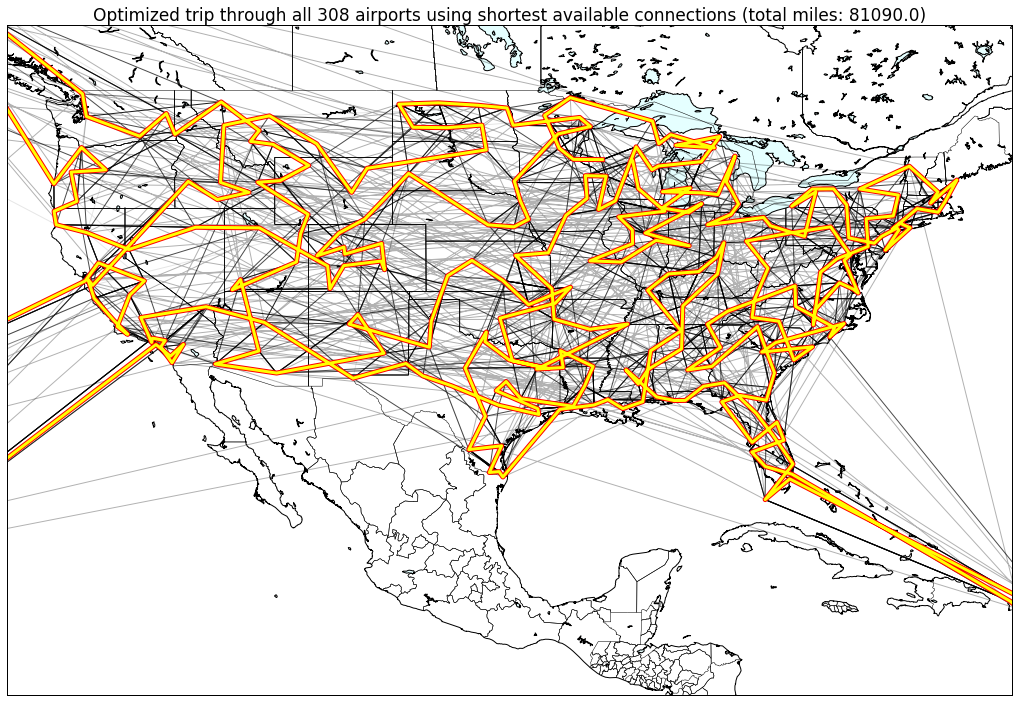

In [45]:
#plot on map
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap

def plot_paths(longitude, latitude, df_all_paths_for_plot, shortest_trip_in):
    figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 18))
    
    #reset index
    new_index = [i for i in range(1,len(df_all_paths_for_plot.columns)+1)]
    df_all_paths_for_plot.columns=(new_index)
    
    m = Basemap(
                ax=axes,
                projection='cyl',
                lon_0=longitude, lat_0=latitude,
                llcrnrlat=latitude - 20.0, urcrnrlat=latitude + 20.0,
                llcrnrlon=longitude - 30.0, urcrnrlon=longitude + 30.0,
                resolution='i'
                )

    
    m.fillcontinents(color='white', alpha = 0.1,lake_color='aqua')

    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    m.drawstates()
    
        
    #grab two columns at time for plotting
    for i in range(1, len(df_all_paths_for_plot.columns)+1, 2):
        #Convert latitude and longitude to coordinates X and Y
        x, y = m(df_all_paths_for_plot[i], df_all_paths_for_plot[i+1])
        #Plot the points on the map
        plt.plot(x,y,'-', color = 'black', alpha = (0.1+(i*0.2)))
    
    
    plt.plot(df_all_paths_for_plot[len(df_all_paths_for_plot.columns)-3],
             df_all_paths_for_plot[len(df_all_paths_for_plot.columns)-2],'-', color = 'black',
            label = 'Previous model iterations')  
    
    plt.plot(df_all_paths_for_plot[len(df_all_paths_for_plot.columns)-1],
             df_all_paths_for_plot[len(df_all_paths_for_plot.columns)],'-', linewidth=5, color = 'red')   
    plt.plot(df_all_paths_for_plot[len(df_all_paths_for_plot.columns)-1],
             df_all_paths_for_plot[len(df_all_paths_for_plot.columns)],'-', linewidth=3.0, color = 'yellow',
            label = 'Last/best model iteration')   
   
    title_string = 'Optimized trip through all 308 airports using shortest available connections (total miles: %s)' %shortest_trip_in
    plt.title(title_string, fontsize=17)
    plt.savefig("Flight_Fig11.png", bbox_inches="tight") 
    plt.show()
      
plot_paths(-97.0372,32.895951, df_all_paths_for_plot, shortest_trip)   

## 6. Predict future delays by finding classifiers for a given a day in January, city of origin and the length of the flight using Random Forests

#### 6A. Query mongoDB for the airport coordinates, day of month, trip lenght and delays

In [71]:
return_fields = ['AIR_TIME','DAY_OF_MONTH','ORIGIN_AIRPORT_ID','DEP_DELAY_GROUP']
collection = 'flights_januar15'

In [72]:
import pandas as pd

def rado_to_pandas(db, collection, return_fields):
    cursor = db[collection_name].find(
            { "AIR_TIME": { '$gt': 0 } }
            ).batch_size(30)   
    
    return pd.DataFrame(list(cursor), columns = return_fields)

#load data for random forrest
df_randFo = rado_to_pandas(db, collection, return_fields)
print df_randFo.head()

   AIR_TIME  DAY_OF_MONTH ORIGIN_AIRPORT_ID  DEP_DELAY_GROUP
0       499             1             11298               12
1       490             1             11298               11
2       420             1             12173                7
3       190             1             11298                3
4       178             1             14771                2


In [74]:

#df_randFo.to_csv('df_randof_data.csv')
#load saved data
df_temp = pd.read_csv('df_randof_data.csv')
df_temp = df_temp.drop('Unnamed: 0', 1)

In [75]:
#### 6B. Train a Random Forest model

In [76]:
#prepare data and split into 80% training, 20% testing portions
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
#covert to array
import numpy as np
df_randFo = df_randFo.convert_objects(convert_numeric=True)
data_array_data = np.array(df_randFo.ix[:,0:3])
#preproccess
data_array_data = preprocessing.scale(data_array_data) 
print data_array_data[0]
#convert delay group to target (that is what we want to predict)
data_array_target = np.array(df_randFo.ix[:,3:4])
print data_array_target[0]
X_train, X_test, y_train, y_test = train_test_split(data_array_data, data_array_target, test_size=0.2, random_state=33)

[ 5.39119659 -1.65991085 -0.90389326]
[ 12.]


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


#### 6B. Find classifiers using training data

In [84]:
#find classifiers
from sklearn.ensemble import RandomForestClassifier
def create_classifiers(X_train_in, y_train_in):
    clf = RandomForestClassifier(n_estimators=100)
    return clf.fit(X_train_in,y_train_in)

In [85]:
classifiers = create_classifiers(X_train, y_train)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


#### 6C. Measure prediction performance using test data

Accuracy:0.470 

Classification report
             precision    recall  f1-score   support

       -2.0       0.06      0.02      0.03       386
       -1.0       0.61      0.73      0.66     50567
        0.0       0.28      0.23      0.25     22162
        1.0       0.11      0.08      0.09      6923
        2.0       0.07      0.05      0.05      3482
        3.0       0.05      0.03      0.04      2169
        4.0       0.03      0.02      0.02      1502
        5.0       0.02      0.01      0.02      1061
        6.0       0.02      0.01      0.01       725
        7.0       0.01      0.01      0.01       523
        8.0       0.00      0.00      0.00       408
        9.0       0.02      0.01      0.01       326
       10.0       0.01      0.00      0.01       249
       11.0       0.02      0.01      0.01       182
       12.0       0.04      0.02      0.03       738

avg / total       0.42      0.47      0.44     91403


Confusion matrix
[[    8   307    39    15     5     2  

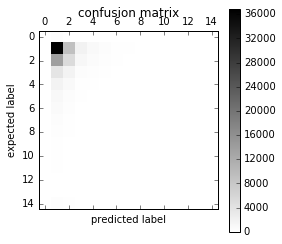

In [111]:
#measure performance of classi
from sklearn import metrics
def measure_performance(X,y,clf,show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    
    y_pred=clf.predict(X)   
    if show_accuracy:
        print "Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n"

    if show_classification_report:
        print "Classification report"
        print metrics.classification_report(y,y_pred),"\n"
        
    if show_confusion_matrix:
        print "Confusion matrix"
        print metrics.confusion_matrix(y,y_pred),"\n"
        plt.matshow(metrics.confusion_matrix(y, y_pred ), cmap=plt.cm.binary, interpolation='nearest')
        plt.title('confusion matrix')
        plt.colorbar()
        plt.ylabel('expected label')
        plt.xlabel('predicted label')
        plt.savefig('Flights_Fig9.png', dpi=300, bbox_inches="tight")
        
measure_performance(X_test,y_test,classifiers)